In [1]:
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression

from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import mean_squared_error


def evaluate_regressor(model, regressor, X_calibration, y_calibration, method):
    y_true_residuals = get_residual(
        model=model, X=X_calibration, y=y_calibration, method=method
    )
    y_pred_residuals = regressor.predict(X_calibration)
    mse = mean_squared_error(y_true=y_true_residuals, y_pred=y_pred_residuals)
    rmse = np.sqrt(mse)
    print(f"Fitted regressor MSE = {mse}")
    print(f"Fitted regressor RMSE = {rmse}")


def count_null_set(y: np.ndarray) -> int:
    """
    Count the number of empty prediction sets.

    Parameters
    ----------
    y: np.ndarray of shape (n_sample, )

    Returns
    -------
    int
    """
    count = 0
    for pred in y[:, :]:
        if np.sum(pred) == 0:
            count += 1
    return count


def get_residual(model, X, y, method):
    if method == "crf_score":
        y_pred_proba = model.predict_proba(X)
        y = y.to_numpy()
        y_res_predict_new = np.take_along_axis(
            1 - y_pred_proba, np.expand_dims(y, axis=1), axis=1
        )[:, 0]
    elif method == "crf_aps":
        y_pred_proba = model.predict_proba(X)
        cum_sum_proba = _get_true_label_cumsum_proba(y, y_pred_proba=y_pred_proba)
        y_res_predict_new = cum_sum_proba[0].ravel()
    return y_res_predict_new


def _get_true_label_cumsum_proba(
    y,
    y_pred_proba,
):
    y_true = label_binarize(y=y, classes=np.unique(y))
    index_sorted = np.fliplr(np.argsort(y_pred_proba, axis=1))
    y_pred_proba_sorted = np.take_along_axis(y_pred_proba, index_sorted, axis=1)
    y_true_sorted = np.take_along_axis(y_true, index_sorted, axis=1)
    y_pred_proba_sorted_cumsum = np.cumsum(y_pred_proba_sorted, axis=1)
    cutoff = np.argmax(y_true_sorted, axis=1)
    true_label_cumsum_proba = np.take_along_axis(
        y_pred_proba_sorted_cumsum, cutoff.reshape(-1, 1), axis=1
    )

    return true_label_cumsum_proba, cutoff + 1


def visualize_dataset(X, y, title="Plot"):
    unique_classes = np.unique(y)
    colors = plt.cm.turbo(np.linspace(0, 1, len(unique_classes)))
    for i, cls in enumerate(unique_classes):
        class_indices = y == cls
        plt.scatter(
            X.loc[class_indices, "x"],
            X.loc[class_indices, "y"],
            color=colors[i],
            label="Class {}".format(cls),
        )
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    plt.legend(title="Classes")
    plt.show()


def visualize_test_dataset(X, title="Plot"):
    plt.scatter(X["x"], X["y"])
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    plt.show()


def mask_dataset(X, y, random_state, random_curve = True):
    X_copy = X.copy()
    y_copy = y.copy()
    # Générer les pentes et intercepts aléatoires pour chaque classe
    np.random.seed(random_state)  # Pour reproduire les mêmes valeurs aléatoires
    if random_curve:
        slopes = np.random.uniform(
            low=-2.0, high=2.0, size=4
        )  # Pentes aléatoires entre -2.0 et 2.0
        intercepts = np.random.uniform(
            low=-1.0, high=1.0, size=4
        )  # Intercepts aléatoires entre -1.0 et 1.0
    else:
        slopes = [1, 1, 1, 1]
        intercepts = [0, 0, 0, 0]
    for cls, slope, intercept in zip(range(4), slopes, intercepts):
        class_indices = y_copy == cls
        X_class = X_copy[class_indices]

        # Calculer les valeurs de y prédites pour chaque point
        y_predicted = slope * X_class["x"] + intercept
        nb_mask_left = len(X_class[np.sign(X_class["y"] - y_predicted) < 0].index)
        nb_mask_right = len(X_class[np.sign(X_class["y"] - y_predicted) > 0].index)

        if (nb_mask_left > nb_mask_right) or (not random_curve):
            # Supprimer les points situés d'un côté de la droite
            mask = np.sign(X_class["y"] - y_predicted) > 0
        else:
            # Supprimer les points situés de l'autre côté de la droite
            mask = np.sign(X_class["y"] - y_predicted) < 0
        X_copy = X_copy.drop(X_class[mask].sample(frac=0.9, random_state=42).index)
        y_copy = y_copy.drop(X_class[mask].sample(frac=0.9, random_state=42).index)

    return X_copy, y_copy


def visualize_all_datasets(X1, y1, X_train_masked, y_train_masked, X_test):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    unique_classes = np.unique(y1)
    colors = plt.cm.turbo(np.linspace(0, 1, len(unique_classes)))
    for i, cls in enumerate(unique_classes):
        class_indices = y1 == cls
        axes[0].scatter(
            X1.loc[class_indices, "x"],
            X1.loc[class_indices, "y"],
            color=colors[i],
            label="Class {}".format(cls),
        )
    axes[0].set_xlabel("x1")
    axes[0].set_ylabel("x2")
    axes[0].set_title("Classification dataset")

    for i, cls in enumerate(unique_classes):
        class_indices = y_train_masked == cls
        axes[1].scatter(
            X_train_masked.loc[class_indices, "x"],
            X_train_masked.loc[class_indices, "y"],
            color=colors[i],
            label="Class {}".format(cls),
        )
    axes[1].set_xlabel("x1")
    axes[1].set_ylabel("x2")
    axes[1].set_title("Masked Classification dataset")

    axes[2].scatter(X_test["x"], X_test["y"])
    axes[2].set_xlabel("x1")
    axes[2].set_ylabel("x2")
    axes[2].set_title("Test dataset")

    plt.tight_layout()
    plt.show()


def plot_scores(n, alphas, scores, quantiles):
    colors = {0: "#1f77b4", 1: "#ff7f0e", 2: "#2ca02c"}
    plt.figure(figsize=(4, 3))
    plt.hist(scores, bins="auto")
    for i, quantile in enumerate(quantiles):
        plt.vlines(
            x=quantile,
            ymin=0,
            ymax=400,
            color=colors[i],
            ls="dashed",
            label=f"alpha = {alphas[i]}",
        )
    plt.title("Distribution of scores")
    plt.legend()
    plt.xlabel("Scores")
    plt.ylabel("Count")
    plt.show()


def plot_results(alphas, X, y_pred, y_ps):
    tab10 = plt.cm.get_cmap("Purples", 4)
    colors = {0: "#1f77b4", 1: "#ff7f0e", 2: "#2ca02c", 3: "#d62728"}
    y_pred_col = list(map(colors.get, y_pred))
    fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, figsize=(16, 4))
    axs = {0: ax1, 1: ax2, 2: ax3, 3: ax4}
    axs[0].scatter(X[:, 0], X[:, 1], color=y_pred_col, marker=".", s=10, alpha=0.4)
    axs[0].set_title("Predicted labels")
    for i, alpha in enumerate(alphas):
        y_pi_sums = y_ps[:, :, i].sum(axis=1)
        num_labels = axs[i + 1].scatter(
            X[:, 0],
            X[:, 1],
            c=y_pi_sums,
            marker=".",
            s=10,
            alpha=1,
            cmap=tab10,
            vmin=0,
            vmax=3,
        )
        plt.colorbar(num_labels, ax=axs[i + 1])
        axs[i + 1].set_title(f"Number of labels for alpha={alpha}")
    plt.show()


In [4]:
N_SAMPLES = 5000

X1, y1 = make_gaussian_quantiles(n_samples=N_SAMPLES, n_features=2, n_classes=5, random_state=42)
# noise = np.random.rand(N_SAMPLES, 2)

X1 = pd.DataFrame(X1, columns=['x', 'y']) #+ (noise)
y1 = pd.Series(y1)

# Supprimer les observations de la classe numéro 5
mask = y1 != 4
X1_filtered = X1[mask]
y1_filtered = y1[mask]

X1_filtered["x"] += np.random.normal(scale=.1, size=len(X1_filtered))
X1_filtered["y"] += np.random.normal(scale=.1, size=len(X1_filtered))

## Création du mesh de test
x_min, x_max, y_min, y_max, step = -1.5, 1.5, -1.5, 1.5, 0.01

xx, yy = np.meshgrid(
    np.arange(x_min, x_max, step), np.arange(x_min, x_max, step)
)
X_test_mesh = np.stack([xx.ravel(), yy.ravel()], axis=1)

In [5]:
X_train_masked, y_train_masked = mask_dataset(X1_filtered, y1_filtered, random_state=10, random_curve=False)
X_train_masked, X_test, y_train_masked, y_test = train_test_split(X_train_masked, y_train_masked, test_size=0.25, random_state=42)
X_train_masked, X_cal_masked, y_train_masked, y_cal_masked = train_test_split(X_train_masked, y_train_masked, test_size=1/3)
X_train_masked, X_res_masked, y_train_masked, y_res_masked = train_test_split(X_train_masked, y_train_masked, test_size=1/2)

In [6]:
print(X_train_masked.shape)
print(X_test.shape)
print(X_cal_masked.shape)
print(X_res_masked.shape)

(551, 2)
(552, 2)
(551, 2)
(551, 2)


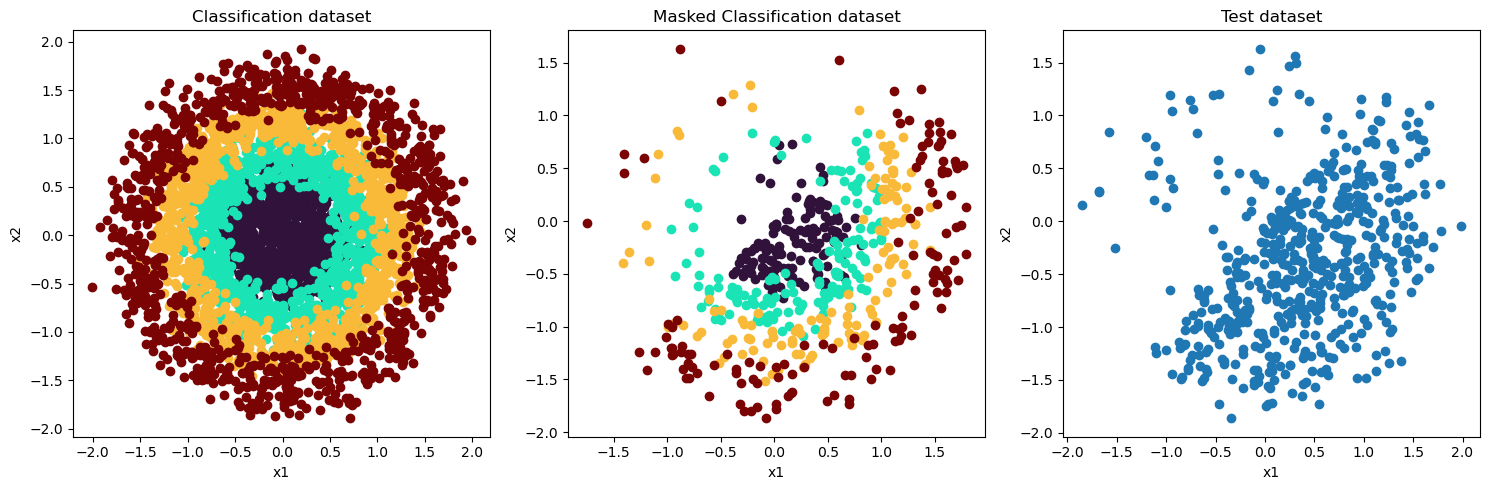

In [7]:
visualize_all_datasets(X1_filtered, y1_filtered, X_train_masked, y_train_masked, X_test)

# Prediction Model

In [8]:
# # SVC Classifier
# param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],'kernel': ['rbf'], 'probability': [True]}

# grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=1)
# grid.fit(X_train_masked, y_train_masked)
# grid_predictions = grid.predict(X_test)

# print(grid.best_estimator_)
# print(f'Accuracy score is : {accuracy_score(y_test, grid_predictions):.3f}')

In [9]:
grid = SVC(probability=True).fit(X_train_masked, y_train_masked)
grid_predictions = grid.predict(X_test)

print(f'Accuracy score is : {accuracy_score(y_test, grid_predictions):.3f}')

Accuracy score is : 0.808


# SCORE Method

In [10]:
mapie_score = MapieClassifier(estimator=grid, cv="prefit", method="score")
mapie_score.fit(X_cal_masked, y_cal_masked)
alpha = [0.2, 0.1, 0.05]
y_pred_score, y_ps_score = mapie_score.predict(X_test_mesh, alpha=alpha)

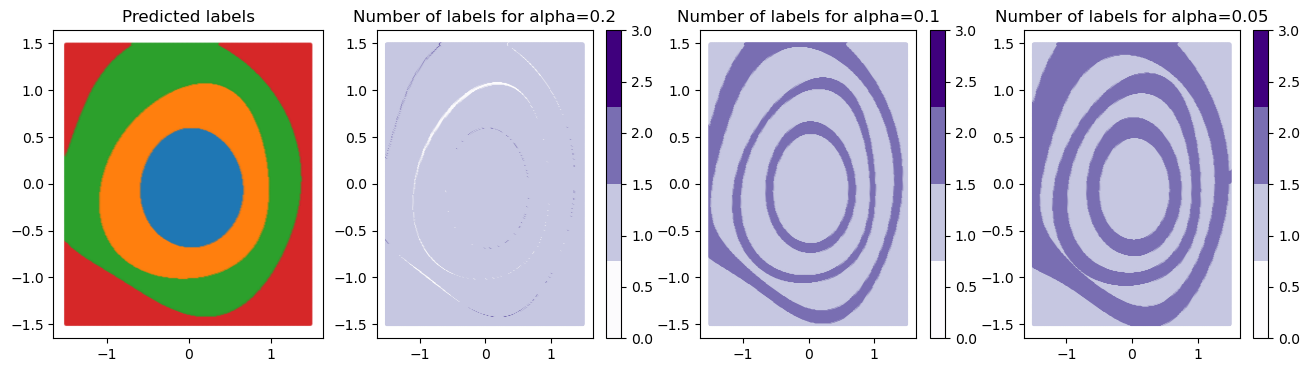

In [11]:
plot_results(alpha, X_test_mesh, y_pred_score, y_ps_score)

## APS Method

In [12]:
mapie_aps = MapieClassifier(estimator=grid, cv="prefit", method="cumulated_score")
mapie_aps.fit(X_cal_masked, y_cal_masked)
y_pred_aps, y_ps_aps = mapie_aps.predict(X_test_mesh, alpha=alpha)

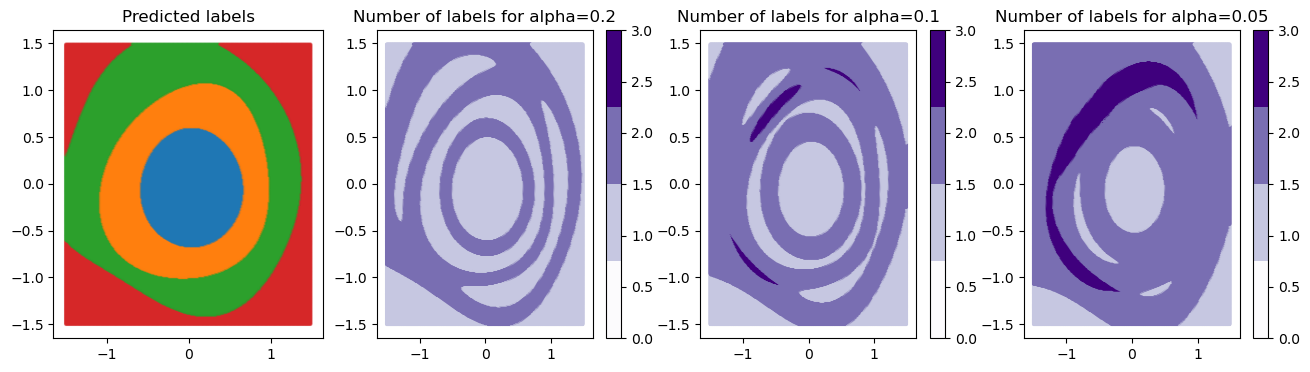

In [13]:
plot_results(alpha, X_test_mesh, y_pred_aps, y_ps_aps)

# CRF-APS

In [14]:
y_res_aps = get_residual(grid, X_res_masked, y_res_masked, 'crf_aps')

# Fit residual predictor
regr_aps = LinearRegression().fit(X_res_masked, y_res_aps)

In [15]:
evaluate_regressor(model=grid, regressor=regr_aps, X_calibration=X_cal_masked, y_calibration=y_cal_masked, method='crf_aps')


Fitted regressor MSE = 0.019134911777536626
Fitted regressor RMSE = 0.13832899832477868


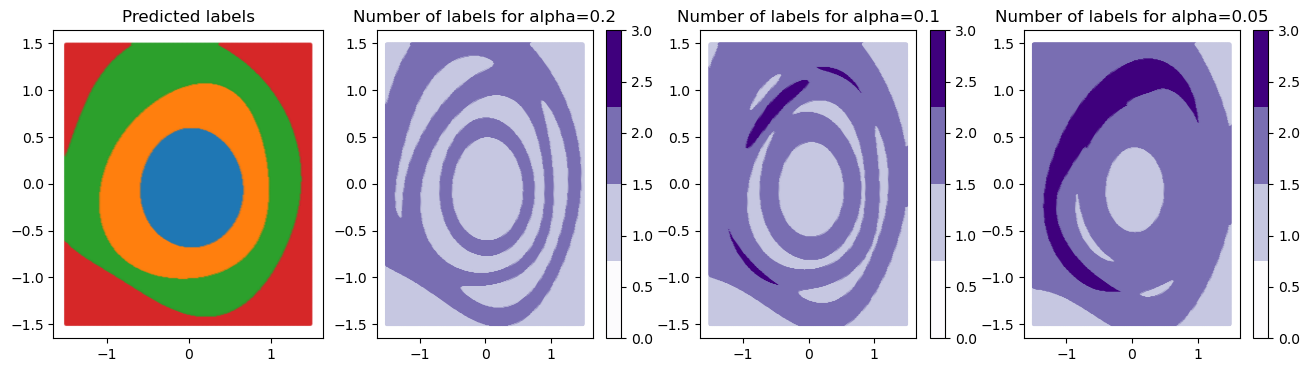

In [16]:
mapie_aps_crf = MapieClassifier(estimator=grid, cv="prefit", method="crf_aps")

y_cal_pred = regr_aps.predict(X_cal_masked)
mapie_aps_crf.fit(X_cal_masked, y_cal_masked, residuals=y_cal_pred)

y_test_pred_res = regr_aps.predict(X_test_mesh)
y_pred_aps_crf, y_ps_aps_crf = mapie_aps_crf.predict(X_test_mesh, alpha=alpha, residuals=y_test_pred_res)

plot_results(alpha, X_test_mesh, y_pred_aps_crf, y_ps_aps_crf)

# CRF-SCORE

In [17]:
y_res_score = get_residual(grid, X_res_masked, y_res_masked, 'crf_score')

# Fit residual predictor
regr_score = LinearRegression().fit(X_res_masked, y_res_score)

In [18]:
evaluate_regressor(
    model=grid, regressor=regr_score,
    X_calibration=X_cal_masked,
    y_calibration=y_cal_masked, method='crf_score'
)


Fitted regressor MSE = 0.06846838510169523
Fitted regressor RMSE = 0.26166464243702325


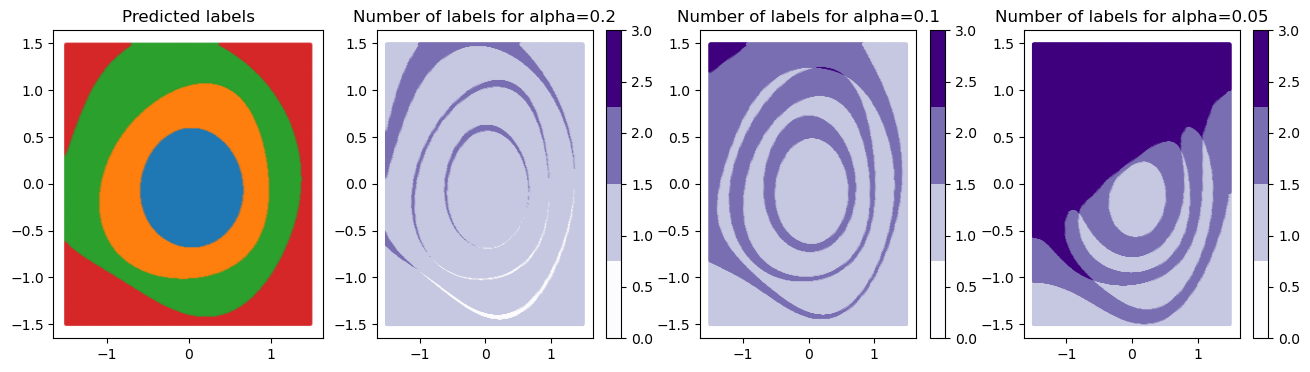

In [19]:
mapie_crf_score = MapieClassifier(estimator=grid, cv="prefit", method="crf_score")

y_cal_pred = regr_score.predict(X_cal_masked)
mapie_crf_score.fit(X_cal_masked, y_cal_masked, residuals=y_cal_pred)

y_test_pred_res = regr_score.predict(X_test_mesh)
y_pred_crf_score, y_ps_crf_score = mapie_crf_score.predict(X_test_mesh, alpha=alpha, residuals=y_test_pred_res)

plot_results(alpha, X_test_mesh, y_pred_crf_score, y_ps_crf_score)

# Calibration of the methods

In [20]:
method_params = {
    "score": "score",
    "aps": "cumulated_score",
    "crf_score": "crf_score",
    "crf_aps": "crf_aps",
    "raps": "raps"
}

In [21]:
grid

SVC(probability=True)

In [22]:
residual_regressors = {
    "crf_aps": regr_aps,
    "crf_score": regr_score
}

In [23]:
y_preds, y_pss = {}, {}
alphas = np.arange(0.01, 1, 0.01)

for name, method in method_params.items():
    if 'crf' in name:
        y_res_score = get_residual(grid, X_res_masked, y_res_masked, method=method)
        mapie = MapieClassifier(estimator=grid, cv="prefit", method=method)
        y_cal_pred = residual_regressors[name].predict(X_cal_masked)
        mapie.fit(X_cal_masked, y_cal_masked, residuals=y_cal_pred)
        y_test_pred_res = residual_regressors[name].predict(X_test)
        y_preds[name], y_pss[name] = mapie.predict(X_test, alpha=alphas, residuals=y_test_pred_res)
    else:
        mapie = MapieClassifier(estimator=grid, method=method, cv="prefit", random_state=42) 
        mapie.fit(X_cal_masked, y_cal_masked)
        y_preds[name], y_pss[name] = mapie.predict(X_test, alpha=alphas)

In [24]:
nulls, coverages, accuracies, sizes = {}, {}, {}, {}
for name, method in method_params.items():
    accuracies[name] = accuracy_score(y_test, y_preds[name])
    nulls[name] = [
        count_null_set(y_pss[name][:, :, i])  for i, _ in enumerate(alphas)
    ]
    coverages[name] = [
        classification_coverage_score(
            y_test, y_pss[name][:, :, i]
        ) for i, _ in enumerate(alphas)
    ]
    sizes[name] = [
        y_pss[name][:, :, i].sum(axis=1).mean() for i, _ in enumerate(alphas)
    ]

In [25]:
coverage_90 = {method: coverage[9] for method, coverage in coverages.items()}
null_90 = {method: null[9] for method, null in nulls.items()}
width_90 = {method: width[9] for method, width in sizes.items()}
y_ps_90 = {method: y_ps[:, :, 9] for method, y_ps in y_pss.items()}

In [26]:
summary_df = pd.concat(
    [
        pd.Series(coverage_90),
        pd.Series(null_90),
        pd.Series(width_90)
    ],
    axis=1,
    keys=["Coverages", "Number of null sets", "Average prediction set sizes"]
).round(3)

In [27]:
summary_df

,Coverages,Number of null sets,Average prediction set sizes
score,0.908,0,1.248
aps,0.987,0,1.634
crf_score,0.904,0,1.241
crf_aps,0.989,0,1.658
raps,0.991,0,1.674


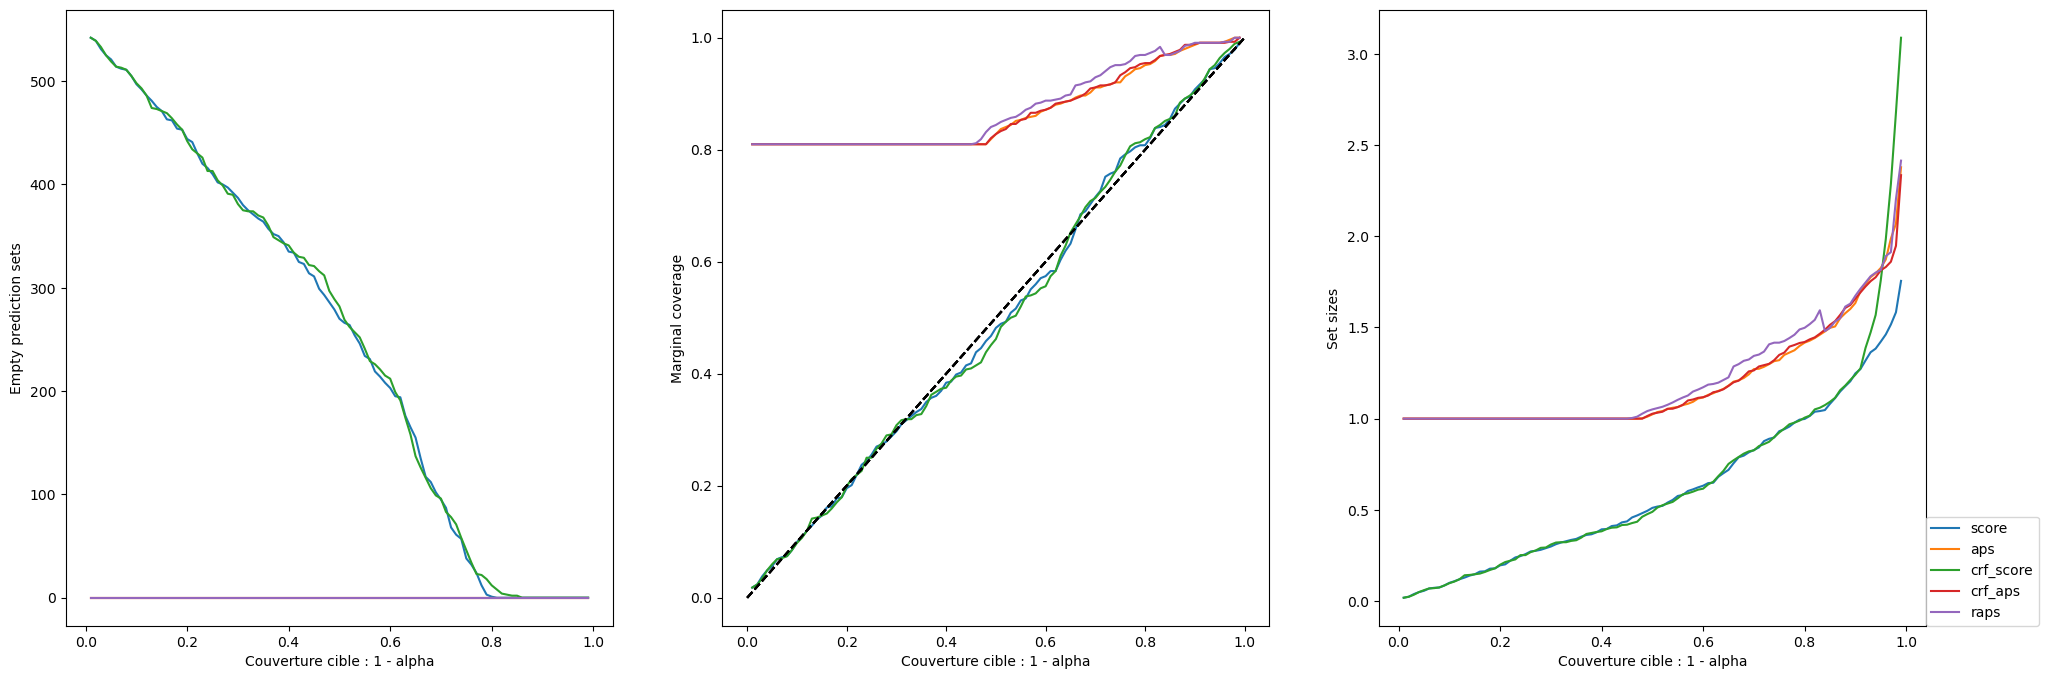

In [28]:
vars_y = [nulls, coverages, sizes]
labels_y = ["Empty prediction sets", "Marginal coverage", "Set sizes"]
fig, axs = plt.subplots(1, len(vars_y), figsize=(8*len(vars_y), 8))
for i, var in enumerate(vars_y):
    for name, method in method_params.items():
        axs[i].plot(1 - alphas, var[name], label=name)
        if i == 1:
            axs[i].plot([0, 1], [0, 1], ls="--", color="k")
    axs[i].set_xlabel("Couverture cible : 1 - alpha")
    axs[i].set_ylabel(labels_y[i])
    if i == len(vars_y) - 1:
        axs[i].legend(fontsize=10, loc=[1, 0])